In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.6.0


## Hyperparameters

In [2]:
batch_size = 16
seq_len = 64

d_k = 128
d_v = 128
n_heads = 8
ff_dim = 128

## Load celltrion data

In [3]:
path = '../data/celltrion-stock-data-2000-2021.csv'

df = pd.read_csv(path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'vol'])
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume
3972,20210806,271000,273000,267500,271500,332369
3973,20210809,270500,271000,264500,266000,351775
3974,20210810,266500,272000,266000,270000,459924
3975,20210811,272000,286000,270500,283000,1870984
3976,20210812,288500,291000,280000,281500,1067756


## Plot daily celltrion closing prices and volume

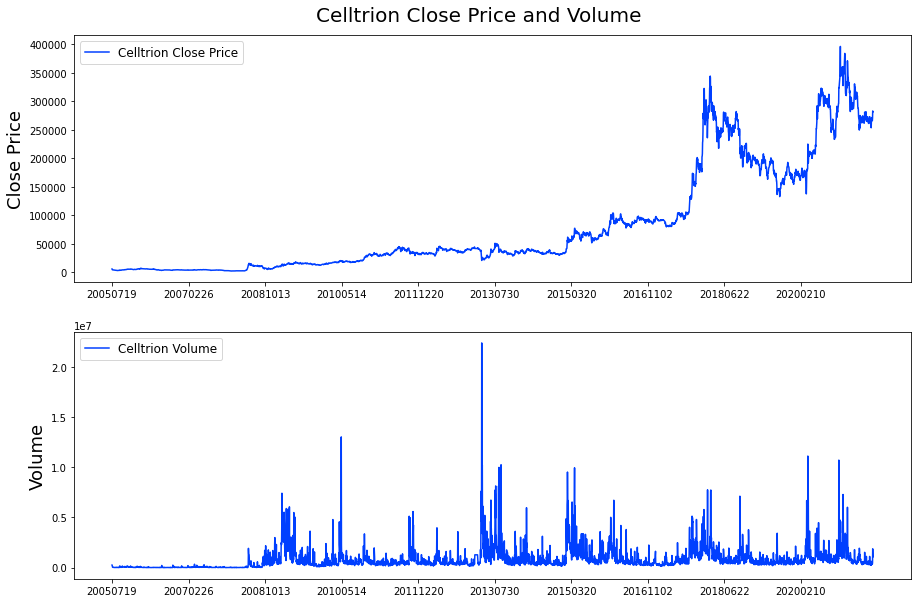

In [4]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Celltrion Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='Celltrion Close Price')
ax1.set_xticks(range(0, df.shape[0], 400))
ax1.set_xticklabels(df['Date'].loc[::400])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='Celltrion Volume')
ax2.set_xticks(range(0, df.shape[0], 400))
ax2.set_xticklabels(df['Date'].loc[::400])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Calculate normalized percentage change of all columns

In [5]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

In [6]:
###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

In [7]:
###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

In [8]:
###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (3181, 5)
Validation data shape: (398, 5)
Test data shape: (397, 5)


,Open,High,Low,Close,Volume
1,0.698996,0.439217,0.452211,0.181091,0.013836
2,0.160255,0.189651,0.223122,0.225998,0.006849
3,0.279251,0.248088,0.380530,0.392541,0.006015
4,0.337097,0.471147,0.431989,0.463305,0.014275
5,0.545832,0.420777,0.460198,0.413432,0.010562


## Plot daily changes of close prices and volume

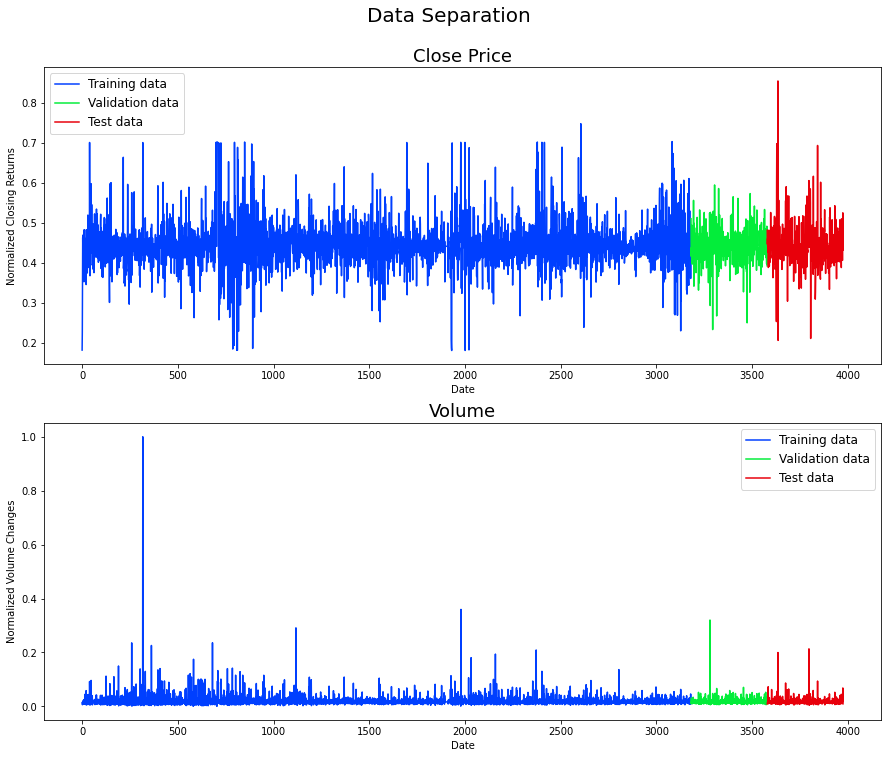

In [9]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Create chunks of training, validation and test data

In [10]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (3117, 64, 5) (3117,)
Validation set shape (334, 64, 5) (334,)
Testing set shape (333, 64, 5) (333,)


## TimeVector

In [11]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer

In [12]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

In [13]:
#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

In [14]:
#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model

In [15]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 5)]      0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 64, 2)        256         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 64, 7)        0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 64, 7)        33706       concatenate[0][0]            

In [17]:
callback = tf.keras.callbacks.ModelCheckpoint('Celltrion_Transformer+TimeEmbedding4.hdf5',
                                              monitor='val_loss',
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=30,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Epoch 1/30
195/195 [==============================] - 31s 93ms/step - loss: 0.0162 - mae: 0.0796 - mape: 18.1295 - val_loss: 0.0024 - val_mae: 0.0370 - val_mape: 9.0650

In [18]:
model = tf.keras.models.load_model('./Celltrion_Transformer+TimeEmbedding4.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


In [19]:
###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0034, MAE: 0.0376, MAPE: 8.7073
Validation Data - Loss: 0.0021, MAE: 0.0334, MAPE: 7.9475
Test Data - Loss: 0.0025, MAE: 0.0342, MAPE: 7.8147


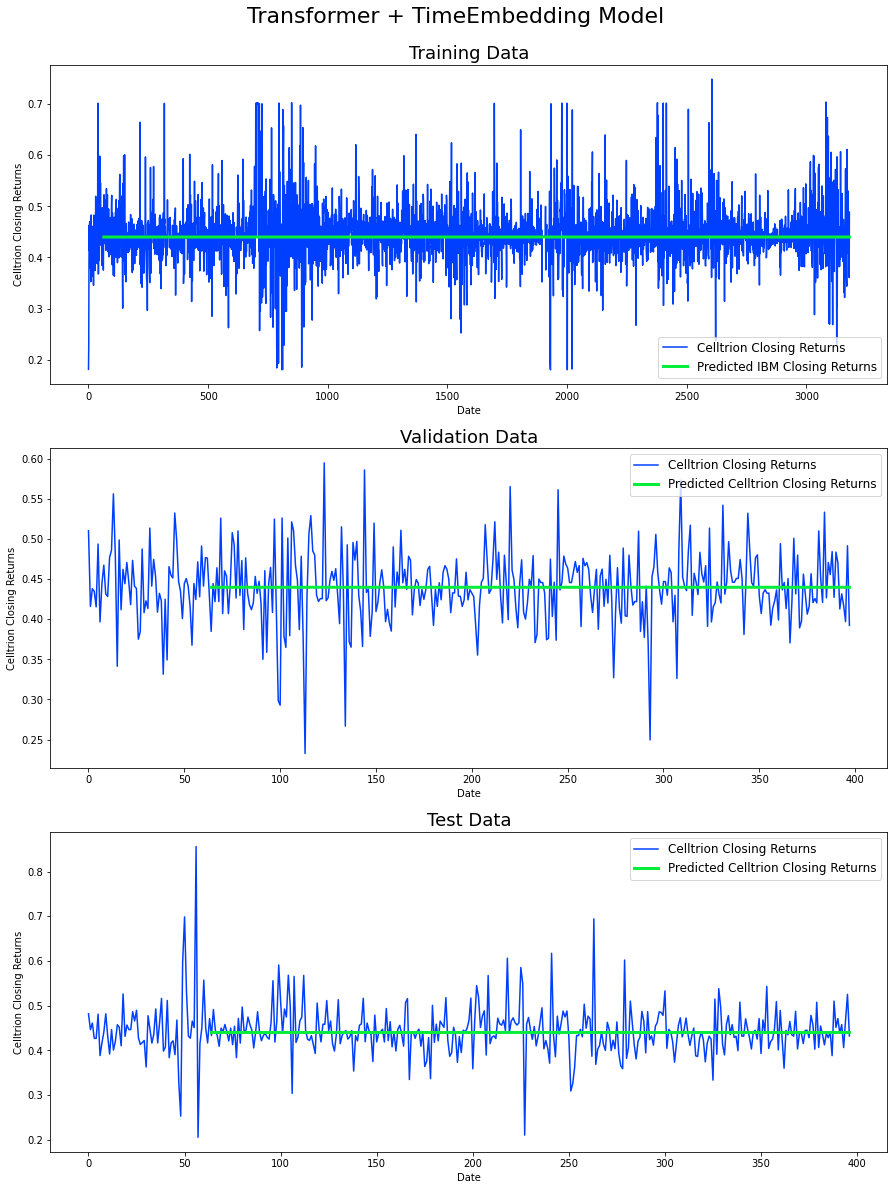

In [20]:

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Celltrion Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Celltrion Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Celltrion Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Celltrion Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Celltrion Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Celltrion Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Celltrion Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Celltrion Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Model metrics

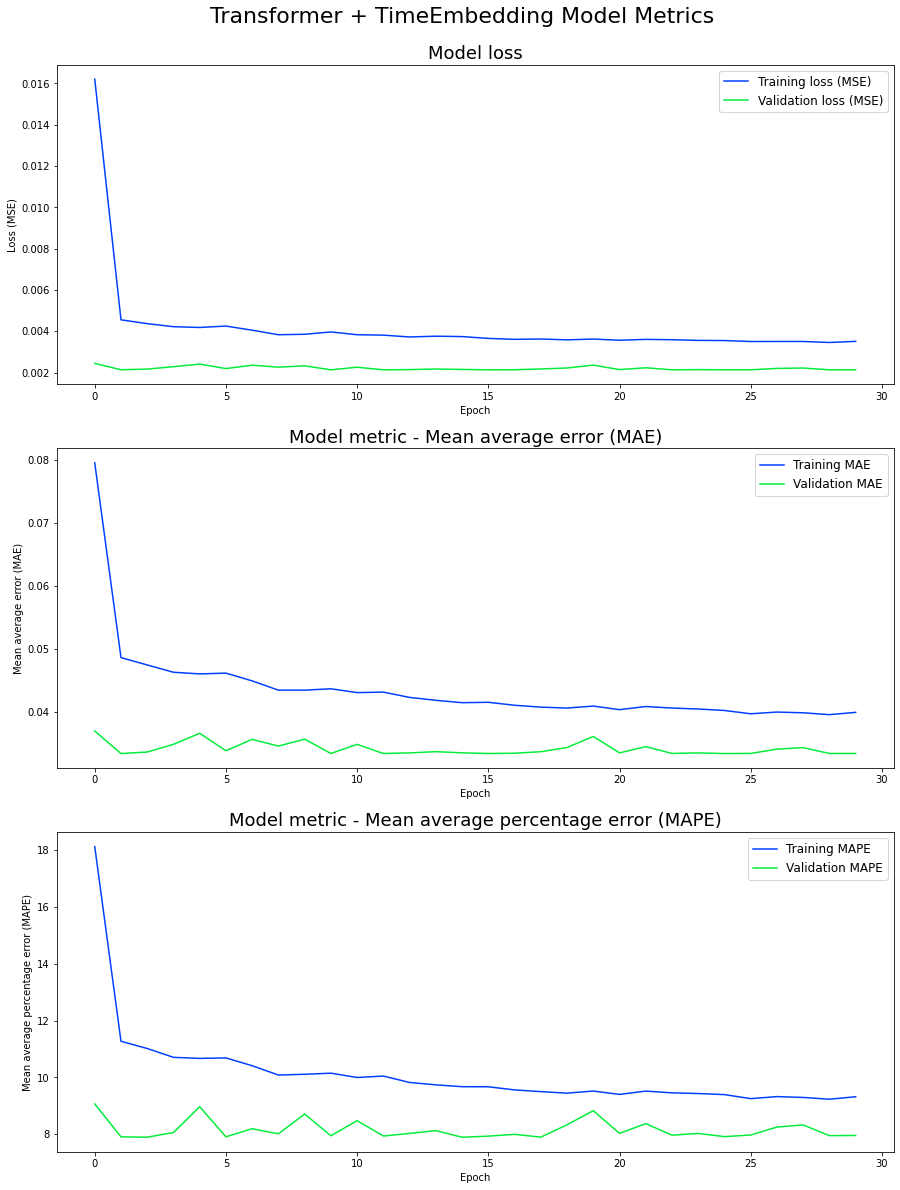

In [21]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

## Model architecture overview

In [22]:
tf.keras.utils.plot_model(
    model,
    to_file="Celltrion_Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Moving Average

## Moving Average - Load IBM data again, to apply rolling window

In [31]:
path = '../data/celltrion-stock-data-2000-2021.csv'

df = pd.read_csv(path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'vol'])
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
df.sort_values('Date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head()

,Date,Open,High,Low,Close,Volume
9,20050801,4447.4,4590.9,4209.7,4334.9,72391.6
10,20050802,4347.5,4417.0,4113.5,4157.3,49530.5
11,20050803,4164.7,4241.6,4001.0,4044.8,29976.3
12,20050804,4061.1,4141.7,3950.7,4001.1,21748.4
13,20050805,3999.7,4082.5,3906.3,3958.2,19151.5


## Moving Average - Plot daily celltrion closing prices and volume

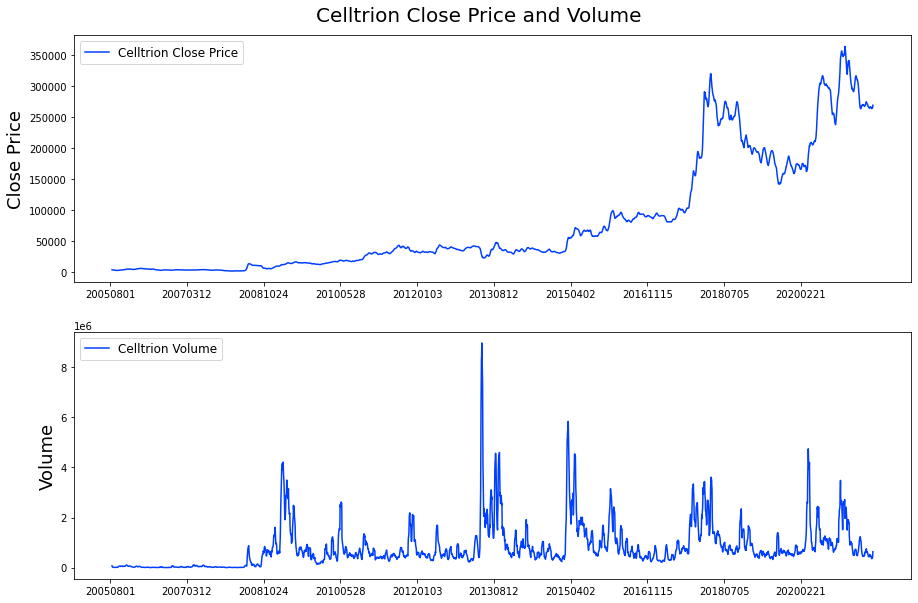

In [32]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Celltrion Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='Celltrion Close Price')
ax1.set_xticks(range(0, df.shape[0], 400))
ax1.set_xticklabels(df['Date'].loc[::400])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='Celltrion Volume')
ax2.set_xticks(range(0, df.shape[0], 400))
ax2.set_xticklabels(df['Date'].loc[::400])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Moving Average - Calculate normalized percentage change for all columns

In [33]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (3174, 5)
Validation data shape: (397, 5)
Test data shape: (396, 5)


,Open,High,Low,Close,Volume
10,0.224260,0.150961,0.222408,0.136268,0.102369
11,0.131145,0.142256,0.201027,0.202397,0.076880
12,0.212786,0.219078,0.271284,0.279690,0.115702
13,0.259174,0.263098,0.277624,0.280079,0.165742
14,0.273880,0.257804,0.272513,0.272440,0.160908


## Moving Average - Plot daily changes of close price and volume

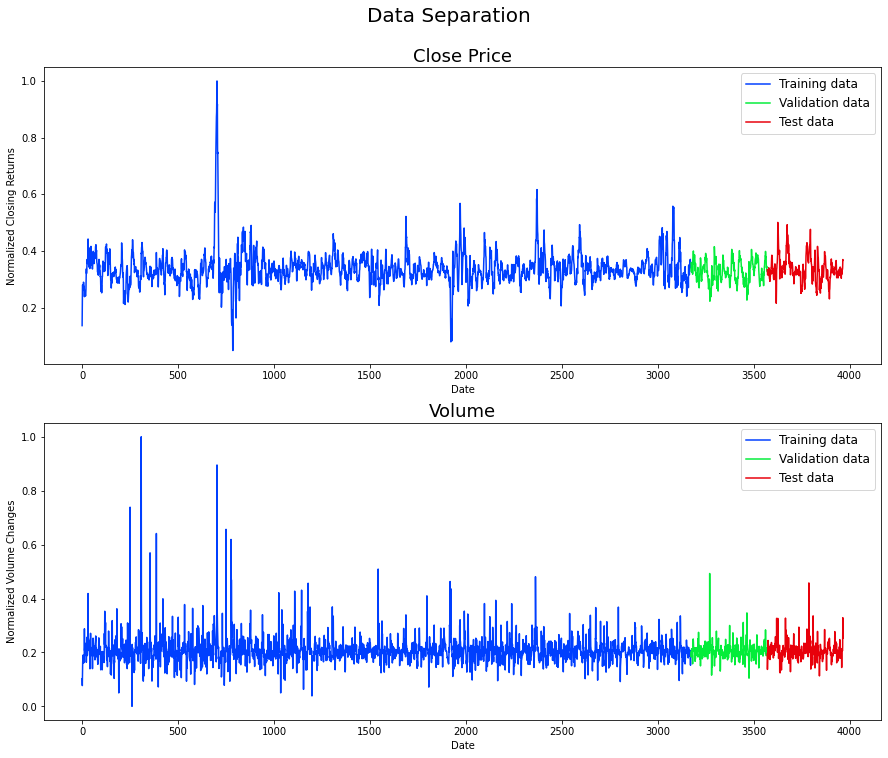

In [34]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Moving Average - Create chunks of training, validation, and test data

In [35]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(3110, 64, 5) (3110,)
(333, 64, 5) (333,)


## Moving Average - Model

In [36]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 5)]      0                                            
__________________________________________________________________________________________________
time2_vector_3 (Time2Vector)    (None, 64, 2)        256         input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 64, 7)        0           input_3[0][0]                    
                                                                 time2_vector_3[0][0]             
__________________________________________________________________________________________________
transformer_encoder_9 (Transfor (None, 64, 7)        33706       concatenate_2[0][0]        

In [37]:
callback = tf.keras.callbacks.ModelCheckpoint('Celltrion_Transformer+TimeEmbedding_mv4.hdf5',
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=30,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

Epoch 1/30
195/195 [==============================] - 42s 141ms/step - loss: 0.0100 - mae: 0.0625 - mape: 18.9670 - val_loss: 0.0016 - val_mae: 0.0328 - val_mape: 10.6630

In [38]:
model = tf.keras.models.load_model('./Celltrion_Transformer+TimeEmbedding_mv4.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0006, MAE: 0.0170, MAPE: 5.4638
Validation Data - Loss: 0.0004, MAE: 0.0143, MAPE: 4.5032
Test Data - Loss: 0.0005, MAE: 0.0159, MAPE: 4.7668


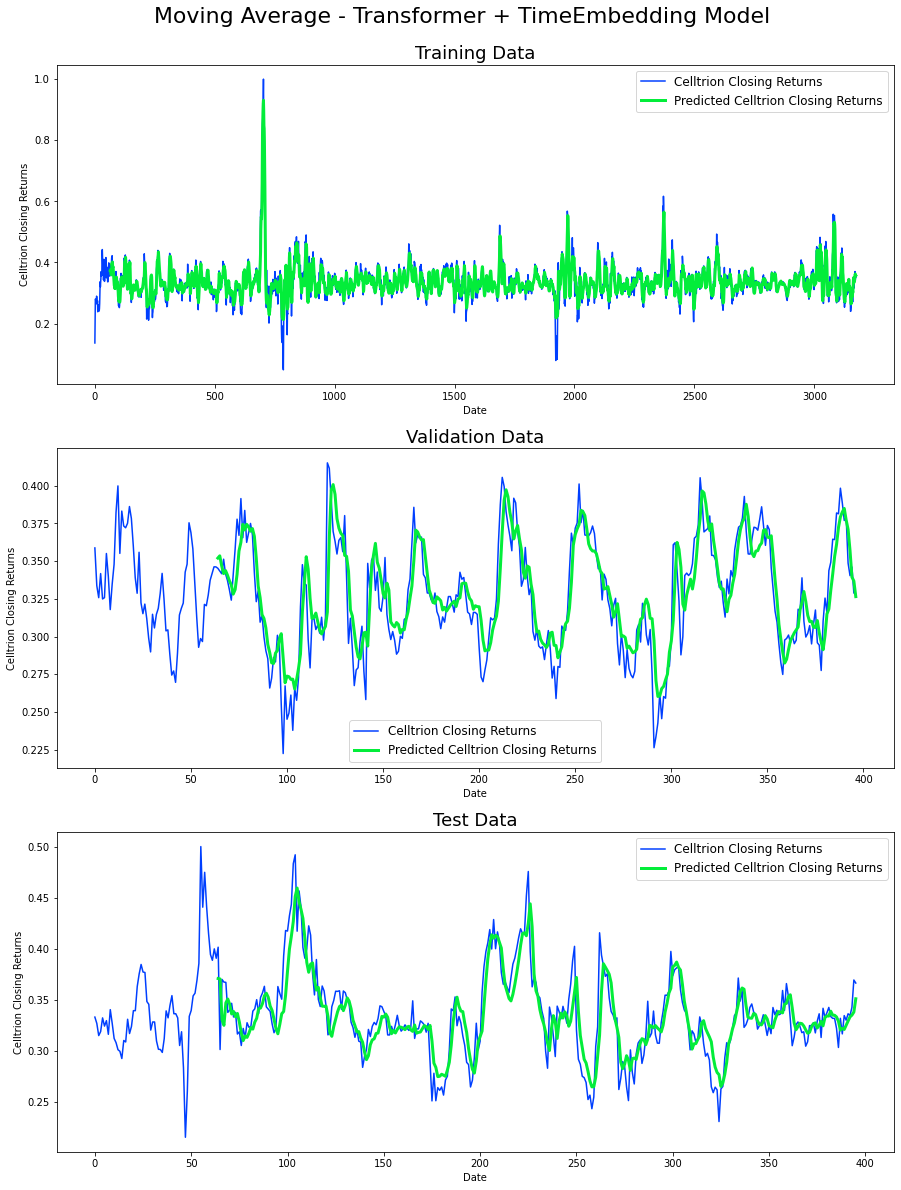

In [39]:
###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Celltrion Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Celltrion Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Celltrion Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Celltrion Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Celltrion Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Celltrion Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Celltrion Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Celltrion Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Celltrion Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Moving Average - Model metrics

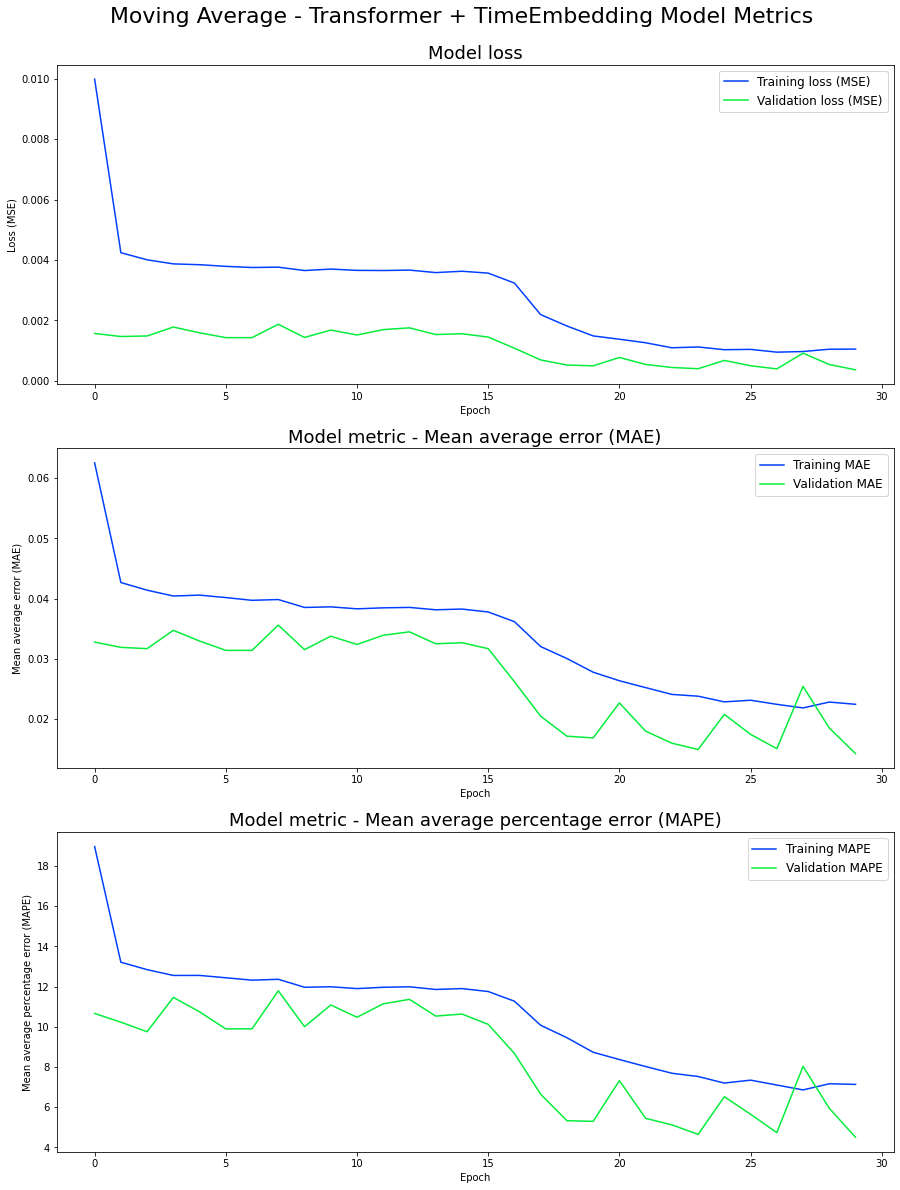

In [40]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)